In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from joblib import Memory
import scipy.stats as st

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer  # Using RobustScaler for robust scaling
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neural_network import MLPRegressor

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [6]:
train_file = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\train_cleaned_FE.csv"
df = pd.read_csv(train_file)

In [ ]:
df = df.drop(columns=['MRP_by_Outlet_Type'])
categorical_cols = ['Item', 'Outlet', 'Outlet_Type','Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']
numerical_cols = ['Item_MRP', 'Item_Weight', 'Item_Visibility','Years_Since_Establishment', 
                  'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item                        8523 non-null   object 
 1   Item_Weight                 8523 non-null   float64
 2   Item_Fat_Content            8523 non-null   object 
 3   Item_Visibility             8523 non-null   float64
 4   Item_Type                   8523 non-null   object 
 5   Item_MRP                    8523 non-null   float64
 6   Outlet                      8523 non-null   object 
 7   Years_Since_Establishment   8523 non-null   int64  
 8   Outlet_Size                 8523 non-null   object 
 9   Outlet_Location_Type        8523 non-null   object 
 10  Outlet_Type                 8523 non-null   object 
 11  Item_Outlet_Sales           8523 non-null   float64
 12  Mean_Sales_Outlet_Type      8523 non-null   float64
 13  Avg_Sales_by_Location_Type  8523 

In [9]:
def tune_model(model, param_distributions, X, y, preprocessor, n_iter=10, cv=5, random_state=42):
    """
    Build a pipeline with the preprocessor and the model, and run RandomizedSearchCV.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ], memory=memory)  # Cache intermediate steps
    
    rsearch = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=rmse_scorer,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rsearch.fit(X, y)
    print(f"Best params for {model.__class__.__name__}: {rsearch.best_params_}")
    return rsearch.best_estimator_

In [10]:
memory = Memory(location='cache_dir', verbose=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=memory)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

In [11]:
memory = Memory(location='cache_dir', verbose=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=memory)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [12]:
mlp_params = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': st.loguniform(1e-4, 1e-1),
    'model__learning_rate_init': st.uniform(0.001, 0.01)
}

In [13]:
print("Tuning MLPRegressor...")
mlp_model = tune_model(MLPRegressor(random_state=42, max_iter=500), mlp_params, X, y, preprocessor)


Tuning MLPRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best params for MLPRegressor: {'model__activation': 'tanh', 'model__alpha': 0.06541210527692734, 'model__hidden_layer_sizes': (100,), 'model__learning_rate_init': 0.002818249672071006}


c:\Users\malli\anaconda3\envs\abhi_feb\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
test_file = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\test_cleaned_FE.csv"
test_data = pd.read_csv(test_file)
test_data = test_data.drop(columns=['MRP_by_Outlet_Type'],
                              errors='ignore')

# Choosing the best models based on CV RMSE
predictions = mlp_model.predict(test_data)
test_data['Predicted_Item_Outlet_Sales_mlp'] = predictions
test_data['Predicted_Item_Outlet_Sales_mlp_abs'] = np.abs(predictions)


output_file = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\mlp_maximum.csv"
test_data.to_csv(output_file, index=False)
print("Predictions saved to:", output_file)


Predictions saved to: C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\mlp_maximum.csv


In [19]:
import joblib
model_path = r"C:\Users\malli\Downloads\Di-20250208T185422Z-001\Di\mlp_max.pkl"
with open(model_path,"wb") as f:
    joblib.dump(mlp_model,f)

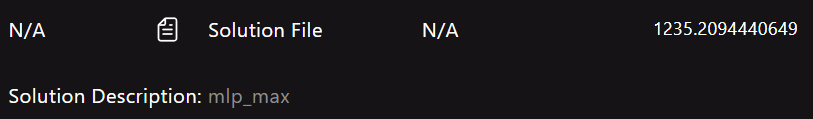